# 风格迁移
 
改变照片的风格

细节：
- 初始化合成图像，这是风格前一种唯一需要更新的变量
- 选择一个预训练的CNN来抽取图像的特征，这些参数无需更新
- 深度CNN凭借多个层逐级抽取图像的特征，可以选择某些层的输出作为内容特征或者是风格特征
- 前向传播计算损失，并通过反向传播迭代模型，不断更新合成的图像。

损失函数有三部分组成：
- 内容损失：合成图像与内容图像在内容特征上需要尽量地接近
- 风格损失：合成图像与风格图像在风格特征上需要尽量地接近
- 总变差损失： 减少合成图像中的噪点

In [30]:
%matplotlib inline
import torch as t
import torchvision as tv
from torch import nn
import sys
sys.path.append("../")
from pltutils import *

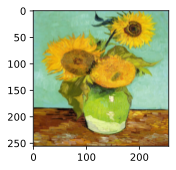

In [31]:
set_figsize()
from PIL import Image
# 读取风格图像和内容图像
style_img =Image.open("../figures/sunflower.jpg")
plt.imshow(style_img)

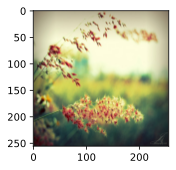

In [32]:
content_img = Image.open("../figures/wheatears.jpg")
plt.imshow(content_img)

# 预处理和后处理

In [33]:
rgb_mean = t.tensor([0.485,0.456,0.406])
rgb_std = t.tensor([0.229,0.224,0.225])

def preprocess(img,image_shape)->t.Tensor:
    """
    图像预处理
    """
    transforms= tv.transforms.Compose([
        tv.transforms.Resize(image_shape),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(rgb_mean,rgb_std),
    ])
    return transforms.__call__(img).unsqueeze(0)

def postprocess(img:t.Tensor)->Image:
    """
    图像后处理
    """
    img = img[0].to(rgb_std.device)
    img = t.clamp(img.permute(1,2,0)*rgb_std+rgb_mean,0,1)
    return tv.transforms.ToPILImage()(img.permute(2,0,1))

# 抽取图像特征
使用基ImageNet数据集预训练的VGG-19模型来抽取图像特征


In [34]:
pretrained_net= tv.models.vgg19(True)

一般来说，越靠近输入层越容易抽取图像的细节信息；反之越远离输入层，越容易抽取图像的全局信息。为了避免图像过多保留内容图像的细节，我们使用VGG靠近输出的层，即内容层，来输出图像的特征。

VGG使用了5个卷积块，在实验中我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。

In [35]:
style_layers ,content_layers = [0,5,10,19,28],[25]

In [36]:
# 打印VGG
for name ,module in pretrained_net.named_children():
    print(name,":",module)

features : Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (

构建新的网络，它只保留需要用到的VGG的所有层。

In [37]:
net  =  nn.Sequential(
    *[pretrained_net.features[i] for i in range(max(content_layers+style_layers)+1)]
)

给定输入X，如果我们简单地调用前向传播的话，我们只能获得中间层的输出，所以在这里需要重新定义函数逐层计算，或者是添加钩子。


In [38]:
def extract_features(X:t.Tensor,content_layers:list,style_layers:list) ->tuple[list[t.Tensor],list[t.Tensor]]:
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i].forward(X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents,styles
    

定义对内容图像抽取内容特征的函数和对风格图像抽取风格特征的函数。

在训练的时候无需改变VGG网络的参数，所以我们在开始训练的时候就可以直接提取出来特征了。

在训练过程中只能使用extract_features来抽取合成图像的内容特征和风格特征。

In [39]:
def get_contents(image_shape,device):
    content_X = preprocess(content_img,image_shape).to(device)
    contents_Y,_ = extract_features(content_X,content_layers,style_layers)
    return content_X,contents_Y

def get_styles(image_shape,device):
    style_X = preprocess(style_img,image_shape).to(device)
    _, styles_Y = extract_features(style_X,content_layers,style_layers)
    return style_X,styles_Y

##  定义损失函数

In [40]:
# 内容损失
def content_loss (Y_hat:t.Tensor,Y:t.Tensor):
    """
    从动态计算的梯度树中分离目标，是一个规定的值
    """
    return t.square(Y_hat- Y.detach()).mean()
# 风格损失 使用Gram矩阵
def gram(X:t.Tensor):
    num_channels ,n = X.shape[1],X.numel()//X.shape[1]
    X = X.reshape((num_channels,n))
    return t.matmul(X,X.T)/(num_channels*n)#后面除以这个玩意是防止数字过大

def style_loss (Y_hat:t.Tensor,gram_Y:t.Tensor):
    return t.square(gram(Y_hat)-gram_Y.detach()).mean()
# 全变分损失,去噪用
def tv_loss(Y_hat:t.Tensor):
    return 0.5 * t.abs(Y_hat[:,:,1:,:] - Y_hat[:,:,:-1,:]).mean()+\
            0.5* t.abs(Y_hat[:,:,:,1:] - Y_hat[:,:,:,:-1]).mean()
# 损失函数，它是上面三个损失函数的加权和
content_weight, style_weight , tv_weight = 1,1e3,10

def compute_loss(X:t.Tensor,contents_Y_hat:t.Tensor,style_Y_hat:t.Tensor,contents_Y:t.Tensor,style_Y_gram:t.Tensor):
    contents_l = [content_loss(Y_hat,Y)*content_weight for Y_hat ,Y in zip(contents_Y_hat,contents_Y)]
    styles_l = [style_loss(Y_hat,Y)*style_weight for Y_hat ,Y in zip(style_Y_hat,style_Y_gram)]
    tv_l = tv_loss(X)*tv_weight

    l= sum(10*styles_l + contents_l +[tv_l])

    return contents_l,styles_l,tv_l,l


初始化合成图像

In [41]:
class SynthesizedImage(nn.Module):
    def __init__(self, image_shape,**kwargs):
        super().__init__(**kwargs)
        self.weight = nn.Parameter(t.rand(*image_shape))
    
    def forward(self):
        return self.weight


创建合成图像的模型实例，图像风格在各个风格层的gram矩阵需要进行提前计算。

In [42]:
def get_inits(X:t.Tensor,device,lr,styles_Y:t.Tensor):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = t.optim.Adam(gen_img.parameters(),lr=lr,)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img.forward(),styles_Y_gram,trainer


训练模型

在训练模型进行风格迁移的时候，我们不断抽取合成图像的内容特征和风格特征，然后计算损失函数。

In [43]:
def train(X:t.Tensor,contents_Y:t.Tensor,styles_Y:t.Tensor,device:t.device,lr,num_epochs,lr_decay_epoch):
    X ,styles_Y_gram ,trainer = get_inits(X,device,lr,styles_Y)
    scheduler = t.optim.lr_scheduler.StepLR(trainer,lr_decay_epoch,0.8)
    animator = Animator(xlabel="epoch",ylabel="loss",xlim = [10, num_epochs],legend=["content", "styles","TV"],ncols=2,figsize=(7,2.5))

    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat ,styles_Y_hat = extract_features(X,content_layers,style_layers)
        contents_l ,styles_l,tv_l,l = compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X


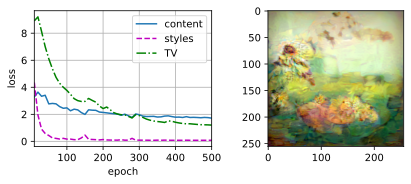

In [44]:
device, image_shape = t.device("cuda:0"), (256, 256)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)
